# 1. Développement d'un jeu

In [1]:
# imports
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# configuration
GAMMA = 0.96
ALPHA = 0.81


In [3]:
#for the space
"""
by default the default space is used
the space is a 2D array 4 * 4 of characters
the characters are: 
    'S' : the starting point
    '_' : empty space
    'J' : the goal
    'D' : a dragon
the default space is:
    S___
    D_D_ 
    ___D
    _D_J
"""

# the default space
default_space = [
        ['S', '_', '_', '_'],
        ['D', '_', 'D', '_'],
        ['_', '_', '_', 'D'],
        ['_', 'D', '_', 'J']
    ]

def get_default_space():
    return default_space

# a random space with number of lines and columns and a number of dragons
def get_random_space(lines, columns, dragons):
    space = []
    for l in range(lines):
        space.append([])
        for c in range(columns):
            space[l].append('_')

    space[0][0] = 'S'
    space[lines-1][columns-1] = 'J'
    
    i = 0
    while i < dragons:
        l = random.randint(0, lines-1)
        c = random.randint(0, columns-1)
        if space[l][c] == '_':
            space[l][c] = 'D'
            i += 1
        else:
            i -= 1

    return space

# pretty print the space
def print_space(space):
    for l in space:
        for c in l:
            print(c, end='| ')
        
        print()

# get the size of the lines
def get_lines_size(space):
    return len(space)

# get the size of the columns
def get_columns_size(space):
    return len(space[0])

# get the size of the space
def get_size(space):
    return get_lines_size(space) * get_columns_size(space)
    

In [4]:
# a static class for the rewards
class Rewards:
    # the rewards for each character
    rewards = {
        'S': 0,
        '_': 0,
        'J': 1,
        'D': -1
    }

    # a method to get the reward of a character
    def get_reward(character):
        return Rewards.rewards.get(character)

    # a method to set the reward 
    def set_rewards(rewards):
        Rewards.rewards = rewards

    # a method to set the reward of a character
    def set_reward(character, reward):
        Rewards.rewards[character] = reward

In [5]:
# a static class for the Directions
class Directions:
    # the directions
    directions = ["HAUT", "DROITE", "BAS", "GAUCHE"]

    # a method to get the size of the directions
    def get_size():
        return len(Directions.directions)

    # a method to get the index of a direction
    def get_index(direction):
        return Directions.directions.index(direction)

    # a method to get a random direction
    def get_random_direction():
        return random.choice(Directions.directions)

    # a method to get the direction that maximizes the Q value
    def get_max_direction(mat_q, state):
        return Directions.directions[np.argmax(mat_q[state])]

In [6]:
# for the Q matrix
# init the Q matrix with zeros and the size of the space and the directions length
def init_mat_q(space):
    return np.zeros((get_lines_size(space), get_columns_size(space), Directions.get_size()))

# get the Q value of a state and a direction
def get_q_value(mat_q, state, direction):
    return mat_q[state][Directions.get_index(direction)]

# update the Q matrix
# according to state, action, reward, next_state, ALPHA and GAMMA
def update_mat_q(mat_q, state, action, reward, next_state):
    mat_q[state][Directions.get_index(action)] += ALPHA * (reward + GAMMA * np.max(mat_q[next_state]) - mat_q[state][Directions.get_index(action)])
    return mat_q

# pretty print the space
def print_mat_q(mat_q, space):
    def get_best_direction(l, c):
        return Directions.directions[np.argmax(mat_q[l][c])]

    for l in range(get_lines_size(space)):
        for c in range(get_columns_size(space)):
            case      = space[l][c]
            direction = get_best_direction(l, c)
            q_value   = str(round(get_q_value(mat_q, (l, c), direction), 2)).ljust(6)

            content = case + " (" + q_value + ") " + direction
            print(content.ljust(20), end='| ')
        print("\n_______________________________________________________________________________________")

In [7]:
def isFin (space, position):
    (l,c) = position

    if(space[l][c]== 'J' or space[l][c]== 'D'):
        return True

    return False

# a method to apply an action to the player
# returns [position, reward, fin]
def applicaion_action(action, position, space):

    # reward -1 every time
    reward = -1

    (l, c) = position
    nextPos = position

    if action == "HAUT":
        nextPos = (l-1,c)
    elif action == "DROITE":
        nextPos = (l,c+1)
    elif action == "BAS":
        nextPos = (l+1,c);
    elif action == "GAUCHE":
        nextPos = (l,c-1);

    # check if the next position is in the space
    if (nextPos[0] < len(space) and nextPos[1] < len(space) and nextPos[0] >=0 and nextPos[1] >=0 ):
        position = nextPos

        # back to the starting point if a dragon is encountered
        # get the current case in the space
        case = space[position[0]][position[1]]
        if case == 'D':
            position = (0, 0)
    
        # set the reward
        reward += Rewards.get_reward(case)

    # check if the player is at the goal
    fin = isFin(space, position)

    # if the player is at the goal, back to the starting point
    if fin:
        position = (0, 0)

    return [position, reward, fin]

# 2. Développement du Q-learning

In [8]:
# a class for the game
class Game:
    # constructor that takes :
    # number of episodes : 10000 by default
    # number of steps : 100 by default
    # is_random_space : False by default
    # a Q matrix : initialized with zeros (with the size of the space and the number of directions)
    def __init__(self, episodes = 10000, steps = 100, is_random_space = False, mat_q = None):
        self.episodes = episodes
        self.steps = steps
        # the space
        if is_random_space:
            self.space = get_random_space(4, 4, 3)
        else:
            self.space = get_default_space()
        
        # the Q matrix 
        if mat_q is None:
            self.mat_q = init_mat_q(self.space)

    # a method to choose an action with the epsilon greedy policy
    def choose_action(self, state, epsilon, mat_q):
        if random.random() < epsilon:
            return Directions.get_random_direction()
        else:
            return Directions.get_max_direction(mat_q, state)

    # a method to play one step (with mat_q, state, epsilon)
    def oneStep(self, mat_q, state, epsilon, verbose):
        # choose an action
        action = self.choose_action(state, epsilon, mat_q)
        if verbose:
            print(action, end=', ')
        # apply the action
        new_state, reward, fin = applicaion_action(action, state, self.space)
        # update the Q matrix
        new_q = update_mat_q(mat_q, state, action, reward, new_state)
        return new_q, new_state, fin


In [9]:
# PLAY
game = Game()

total_steps = 0

# apply the algorithm 
for episode in range(game.episodes):
    # reset the position
    position = (0, 0)
    # calculate the epsilon
    epsilon = game.episodes / (game.episodes + episode)
    #print("epsilon : ", epsilon)

    # play the game
    for step in range(1, game.steps):
        # play one step
        game.mat_q, position, fin = game.oneStep(game.mat_q, position, epsilon, False)
        #print("position : ", game.position)

        # if the game is finished
        if fin:
            total_steps += step
            break

print("total steps : ", total_steps)
print("average steps : ", total_steps / game.episodes)

print(game.mat_q)

total steps :  239875
average steps :  23.9875
[[[-21.396843   -21.24671146 -22.396843   -21.396843  ]
  [-21.24671146 -21.396843   -21.09032444 -21.396843  ]
  [-21.396843   -21.54096928 -22.396843   -21.24671146]
  [-21.54096928 -21.54096928 -21.67933051 -21.396843  ]]

 [[  0.           0.           0.           0.        ]
  [-21.24671146 -22.396843   -20.92742129 -22.396843  ]
  [  0.           0.           0.           0.        ]
  [-21.54096928 -21.67933051 -22.396843   -22.396843  ]]

 [[-22.396843   -20.92742129 -21.24671146 -21.09032444]
  [-21.09032444 -20.75773051 -22.396843   -21.09032444]
  [-22.396843   -22.396843   -20.58096928 -20.92742129]
  [  0.           0.           0.           0.        ]]

 [[-21.09032444 -22.396843   -21.24671146 -21.24671146]
  [  0.           0.           0.           0.        ]
  [-20.75773051 -20.396843   -20.58096928 -22.396843  ]
  [  0.           0.           0.           0.        ]]]


In [10]:
# play a with the optimal policy
for step in range(1, game.steps):
    # play one step
    game.mat_q, position, fin = game.oneStep(game.mat_q, position, 0, True)
    if fin:
        print("fin de partie en", step, "coups")
        break

DROITE, BAS, BAS, DROITE, BAS, DROITE, fin de partie en 6 coups


In [11]:
print_mat_q(game.mat_q, game.space)

S (-21.25) DROITE   | _ (-21.09) BAS      | _ (-21.25) GAUCHE   | _ (-21.4 ) GAUCHE   | 
_______________________________________________________________________________________
D (0.0   ) HAUT     | _ (-20.93) BAS      | D (0.0   ) HAUT     | _ (-21.54) HAUT     | 
_______________________________________________________________________________________
_ (-20.93) DROITE   | _ (-20.76) DROITE   | _ (-20.58) BAS      | D (0.0   ) HAUT     | 
_______________________________________________________________________________________
_ (-21.09) HAUT     | D (0.0   ) HAUT     | _ (-20.4 ) DROITE   | J (0.0   ) HAUT     | 
_______________________________________________________________________________________


# Deep Q-Learning

In [12]:
# IMPORTS
import tensorflow as tf
import sys

2023-01-28 18:35:43.984265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 18:35:44.497142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-28 18:35:44.497199: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-28 18:35:45.839088: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

##### Test avec une structure 2 couches denses ayant 16 entrées (nombre de cases) et 4 sorties (4 actions)


In [13]:
# a class for the game
class DeepGame:
    # constructor that takes :
    # number of episodes : 10000 by default
    # number of steps : 100 by default
    # is_random_space : False by default
    # vec_etat : vector of states (for deep Q learning)
    # a model : CNN
    # the optimizer name
    # the loss function name
    def __init__(
        self, 
        episodes = 10000, 
        steps = 100, 
        is_random_space = False, 
        vec_etat = None, 
        model = None,
        optimizer_name = None,
        loss_fn_name = None
        ):

        self.episodes = episodes
        self.steps = steps
        self.vec_etat = vec_etat
        self.model = model
        self.optimizer_name = optimizer_name
        self.loss_fn_name = loss_fn_name

        # the space
        if is_random_space:
            self.space = get_random_space(4, 4, 3)
        else:
            self.space = get_default_space()

        # the vector of states
        if vec_etat is None:
            self.set_default_vec_etat()

        # the model
        if model is None:
            self.set_default_model()

        # the optimizer
        self.set_optimizer(optimizer_name)

        # the loss function
        self.set_loss_fn(loss_fn_name)



    # a method to set the vector of states
    def set_vec_etat(self, vec_etat):
        self.vec_etat = vec_etat

    # a method to set the default vector of states
    def set_default_vec_etat(self):
        self.vec_etat = np.zeros((1, 16))
        self.vec_etat[0][0] = 1

    # a method to reset the vector of states
    def reset_vec_etat(self):
        self.vec_etat = np.zeros((1, 16))

    # a method to update the vector of states
    def update_vec_etat(self, state):
        self.reset_vec_etat()
        self.vec_etat[0, int(get_lines_size(self.space) * state[0] + state[1])] = 1

    # a method to set the model
    def set_model(self, model):
        self.model = model

    # a method to set the default model
    def set_default_model(self):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(4, activation='relu', input_shape=[16]),
            tf.keras.layers.Dense(4, activation='relu'),
            tf.keras.layers.Dense(4),
        ])

    # a method to save the model
    def save_model(self):

        # number of epochs
        E = "E_" + str(self.episodes)
        # number of steps
        S = "_S_" + str(self.steps)
        # optimizer
        O = "_O_" + str(self.optimizer_name)
        # loss function
        L = "_L_" + str(self.loss_fn_name)
        # dragon reward
        DR = "_DR_" + str(Rewards.rewards["D"])
        # empty reward
        ER = "_ER_" + str(Rewards.rewards["_"])
        # jail reward
        JR = "_JR_" + str(Rewards.rewards["J"])

        # file path
        path = "./seved_models/" + E + S + O + L + DR + ER + JR + ".h5"

        self.model.save(path)

    # a method to set the optimizer
    # optimizer : Nadam by default, SGD,Adam
    def set_optimizer(self, optimizer):
        # set the optimizer according to the name 
        if optimizer == "Adam":
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        elif optimizer == "SGD":
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
        else:
            self.optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)

    # a method to set the loss function
    # loss_fn : MSE by default, MAE
    def set_loss_fn(self, loss_fn):
        # set the loss function according to the name
        if loss_fn == "MAE":
            self.loss_fn = tf.keras.losses.MAE
        else:
            self.loss_fn = tf.keras.losses.mean_squared_error
        

    #####################################################################################################################


    # a method to choose an action with the epsilon greedy policy
    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            action = Directions.get_random_direction()
            #print("random :", action)
            return action
        else:
            Sortie_Q = self.model(self.vec_etat)  # En entrée le vecteur symbolisant l'état
            action = Directions.directions[np.argmax(Sortie_Q)] #On sélectionne l'action associée avec la sortie max
            #print("max    :", action)
            return action
     
    # Train the model
    def train(self, verbose):
        # create a stable model
        model_stable = tf.keras.models.clone_model(self.model)
        model_stable.set_weights(self.model.get_weights())

        history = np.zeros(self.episodes)

        for episode in range(self.episodes):
            # reset the position
            position = (0, 0)
            # calculate the epsilon
            epsilon = self.episodes / (self.episodes + episode)

            for step in range(1, self.steps):
                sys.stdout.write("\r" + "epoch : " + str(episode) + "/" + str(self.episodes) + ", step : " + str(step) + "/" + str(self.steps))
                # play one step
                # choose an action
                action = self.choose_action(position, epsilon)
                # apply the action
                new_position, reward, fin = applicaion_action(action, position, self.space)
                if verbose:
                    print(action, end=", ")

                if fin:
                    if verbose:
                        print("fin de partie en", step, "coups")
                    break

                # set weights of the stable model
                if step % 10 == 0:
                    model_stable.set_weights(self.model.get_weights())

                vec_etat_next = np.zeros((1, 16)) # ca sera l'entree du reseau
                vec_etat_next[0, int(get_lines_size(self.space) * new_position[0] + new_position[1])] = 1

                # model stable predict
                next_Q = model_stable.predict(vec_etat_next, verbose=0)
                next_Q_max = np.max(next_Q)

                # target
                #print("reward : ", reward, "next_Q_max : ", next_Q_max, "(1-fin) : ", (1-fin))
                target = reward + GAMMA * next_Q_max * (1 - fin)

                # gradient descent
                with tf.GradientTape() as tape:
                    predict = self.model(self.vec_etat) # ce que l'on pense obtenir
                    # get index of the action
                    action_index = Directions.get_index(action)
                    mask = tf.one_hot(action_index, Directions.get_size())
                    val_predict = tf.reduce_sum(predict * mask, axis=1)
                    loss = self.loss_fn(target, val_predict)

                gradients = tape.gradient(loss, self.model.trainable_variables) #calcul du gradient de la focntion loss en fonction des variables du modèle 
                self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables)) # optimisation des paramètres du modèle
                history[episode] = loss.numpy() # on récupère la valeur pour afficher l'évolution de l'erreur

                # update the position
                position = new_position

        plt.plot(history, color="red")
        plt.title("Evolution de l'erreur")
        plt.show()

        # save the model
        self.save_model()

    # play the game
    def play(self):

        MAX_ITER = 100
        iter = 0
        position = (0, 0)
        fin = False

        while iter < MAX_ITER and not fin:
            iter += 1
            # update the vector of states
            self.update_vec_etat(position)
            # choose an action
            action = self.choose_action(position, 0)
            # apply the action
            new_position, reward, fin = applicaion_action(action, position, self.space)

            print( str(position) + " (" + str(action) + ") " + str(new_position))
            if iter % 10 == 0:
                print()
            
            if fin:
                print("fin de partie en", iter, "coups")
                break
            # update the position
            position = new_position

        if iter == MAX_ITER:
            print("Trop d'itérations")



In [14]:
# function to create a game with a configuration train and play
def create_game(optimizer_name, loss_fn_name, episodes, steps, dragon_reward, jail_reward, empty_reward):
    # set the rewards
    Rewards.set_rewards({"S": 0, "D": dragon_reward, "J": jail_reward, "_": empty_reward})
    # create the game
    game = DeepGame(episodes=episodes, steps=steps, optimizer_name=optimizer_name, loss_fn_name=loss_fn_name)

    game.train(verbose=False)
    game.play()
    


#### TEST


*   ***optimizer*** : Adam
*   ***loss function*** : MSE
*   ***epochs*** : 10
*   ***steps*** : 50
*   ***Reward Dragon*** : -100
*   ***Reward Empty*** : 0
*   ***Reward Jail*** : 1000



2023-01-28 18:35:54.304480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-28 18:35:54.304568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jugurtha): /proc/driver/nvidia/version does not exist
2023-01-28 18:35:54.306046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


epoch : 9/10, step : 49/50

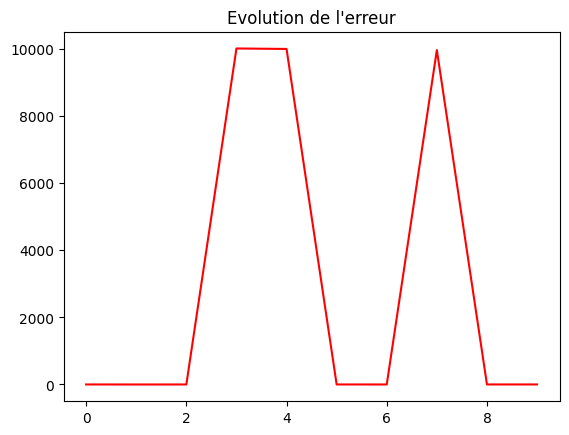

(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)

(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)

(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)

(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)

(0, 0) (DROITE) (0, 1)
(0, 1) (GAUCHE) (0, 0)
(0, 0) (DROITE) (0, 1)
(0, 1) 

In [15]:
game = create_game(optimizer_name="Adam", loss_fn_name="MSE", episodes=10, steps=50, dragon_reward=-100, empty_reward=0, jail_reward=1000)

#### TEST


*   ***optimizer*** : Nadam
*   ***loss function*** : MSE
*   ***epochs*** : 100
*   ***steps*** : 100
*   ***Reward Dragon*** : -100
*   ***Reward Empty*** : 0
*   ***Reward Jail*** : 1000



epoch : 99/100, step : 99/100

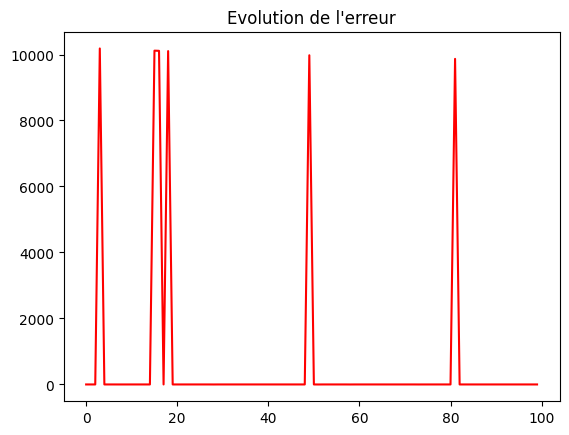

(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)

(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)

(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)

(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)

(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (HAUT) (0, 0)
(0, 0) (H

In [16]:
game = create_game(optimizer_name="Nadam", loss_fn_name="MSE", episodes=100, steps=100, dragon_reward=-100, empty_reward=0, jail_reward=1000)

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
